Unet model segmentation using mobilenet_v2 decoder

#### Collaborators: Esmaeil Shakeri, Mahmoud Khalghollah
#### Chips path Analysis
####Winter  2025

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import csv

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album


In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-tu5_05bw
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-tu5_05bw
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.4 MB/s eta 0:00:0000:01
  Created wheel for segmentation_models_pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=106724 sha256=1b3a847cc81a52c2ee1f016248a3c0aafe872e197a78b9081f9573d875077457


In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
import segmentation_models_pytorch.utils
from segmentation_models_pytorch import utils
# from segmentation_models_pytorch.utils.metrics import Dice
from segmentation_models_pytorch.utils.metrics import Fscore
from segmentation_models_pytorch.utils.metrics import Precision, Recall
from segmentation_models_pytorch.utils.losses import BCEWithLogitsLoss



In [ ]:
# set the data folder name
data_folder = '/kaggle/input/images'
mask_folder = '/kaggle/input/maskimages'
abs_directory = os.path.abspath(data_folder)
abs_directory_mask = os.path.abspath(mask_folder)

# define list of data files
csv_file_paths = [os.path.join(abs_directory, file) for file in os.listdir(abs_directory) if os.path.isfile(os.path.join(abs_directory, file)) and file.endswith('.csv')]
png_file_name = [os.path.join(file) for file in os.listdir(abs_directory) if os.path.isfile(os.path.join(abs_directory, file)) and file.endswith('.png')]

png_file_path = [os.path.join(abs_directory, file) for file in os.listdir(abs_directory) if os.path.isfile(os.path.join(abs_directory, file)) and file.endswith('.png')]
mask_file_path = [os.path.join(abs_directory_mask, file) for file in os.listdir(abs_directory_mask) if os.path.isfile(os.path.join(abs_directory_mask, file)) and file.endswith('.png')]

# create a list from csv files
def load_csv_as_list(csv_file_path):
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [tuple(map(int, row)) for row in csv_reader]
    return data_list

# if masks are not prepared yet
# for i,csv_path in enumerate(csv_file_paths):
#     img = cv2.imread(png_file_path[i])
#     pixels_list = load_csv_as_list(csv_file_paths[i])
#     mask = np.zeros((img.shape[0],img.shape[1]))
#     for item in pixels_list:
#         mask[item] = 255
#     # cv2.imshow('RGB check', mask)
#     # cv2.waitKey(0)
#     cv2.imwrite('./mask/'+png_file_name[i], mask)



In [ ]:
png_file_path[5]

'/kaggle/input/images/MVI_6603frame0982.png'

In [ ]:
mask_file_path[5]

'/kaggle/input/maskimages/MVI_6603frame0982.png'

In [ ]:
# create dataframe
# image_id, train/test, img_path, mask_path

metadata_df = pd.DataFrame({
    'img_path': png_file_path,
    'mask_path': mask_file_path,
})

# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)


(136, 15)

In [ ]:
class_dict = pd.DataFrame({
    'Class Names':  ['background', 'path'],
    'Class RGB values':  [ [0, 0, 0], [255, 255, 255]]
})

class_names = ['background', 'path']
class_rgb_values = [ [0, 0, 0], [255, 255, 255]]

In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'path']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'path']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class RoadsDataset(torch.utils.data.Dataset):

    """DeepGlobe Road Extraction Challenge Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['img_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[i])

        W = 512
        H = 512
        image = cv2.resize(image, (W, H))
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_AREA)
        mask = np.where(mask != 0, 255, mask)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

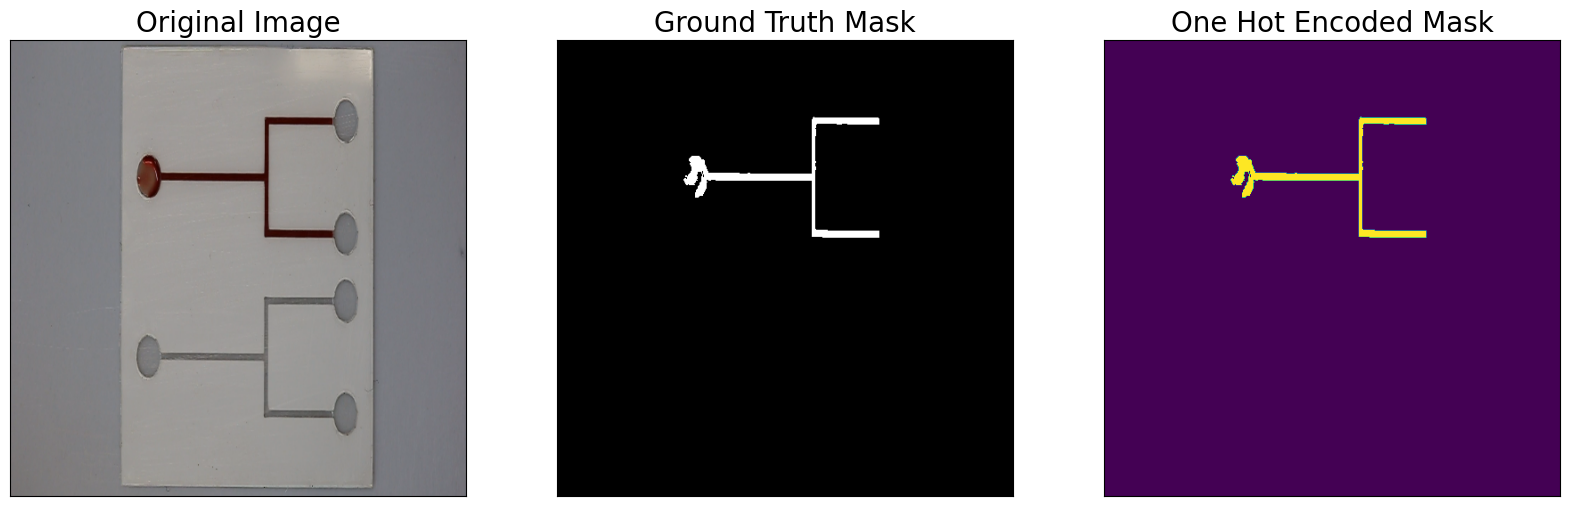

In [ ]:
dataset = RoadsDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

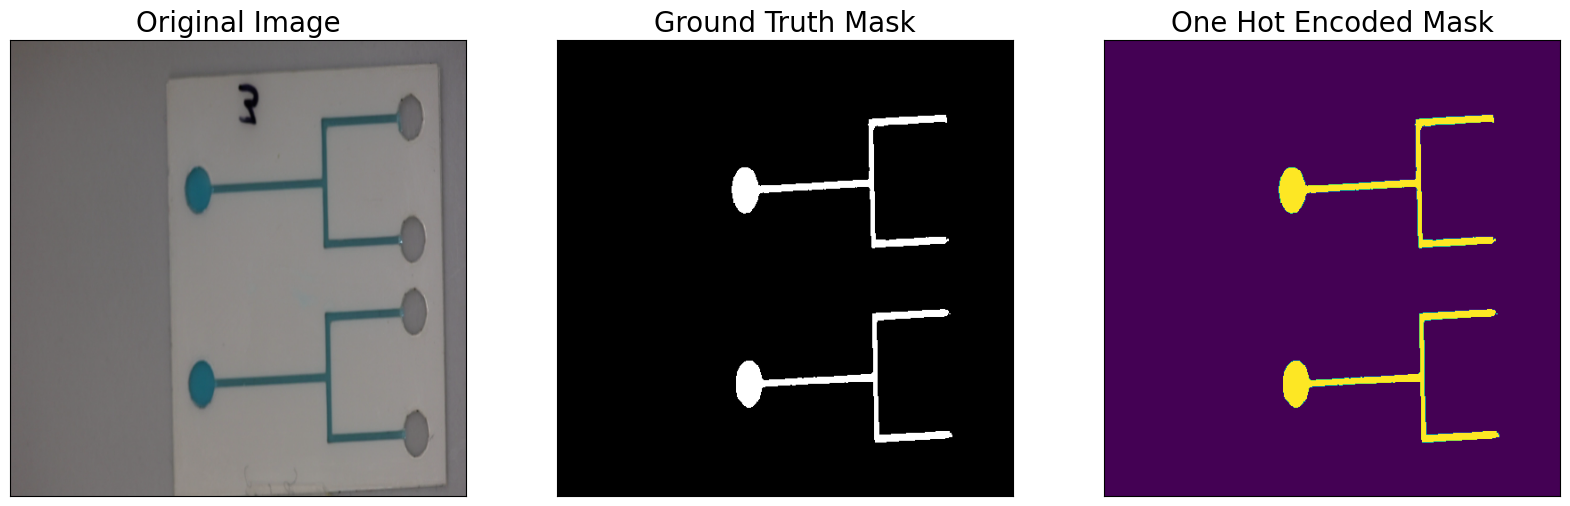

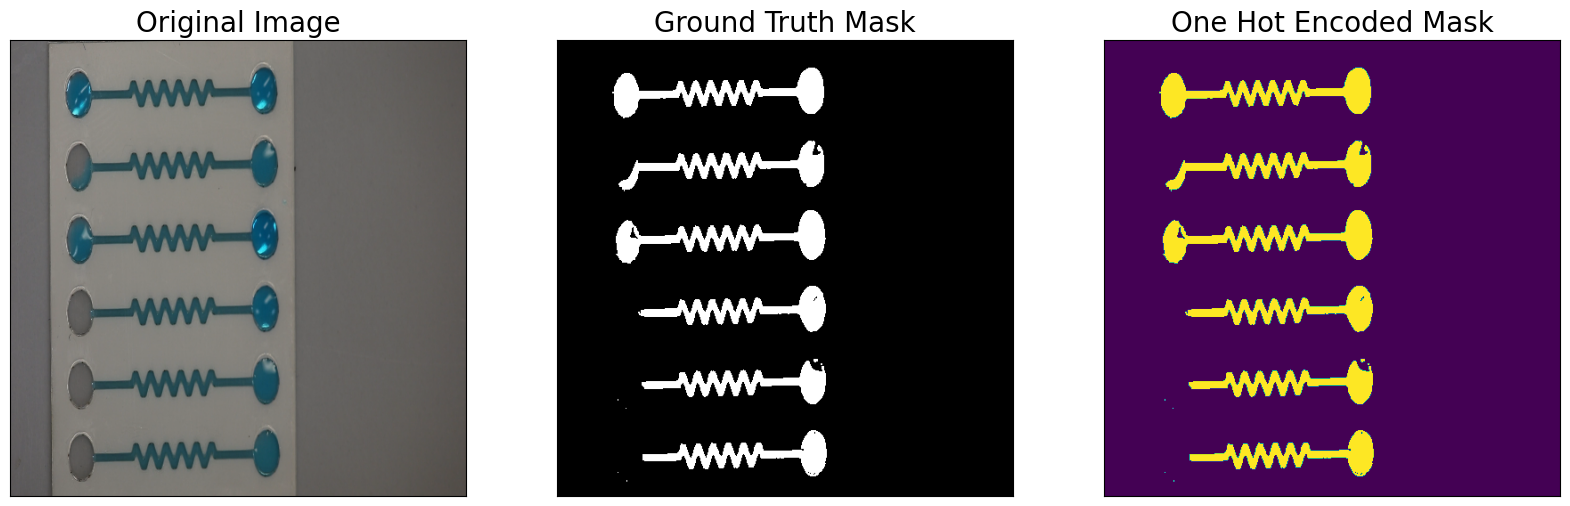

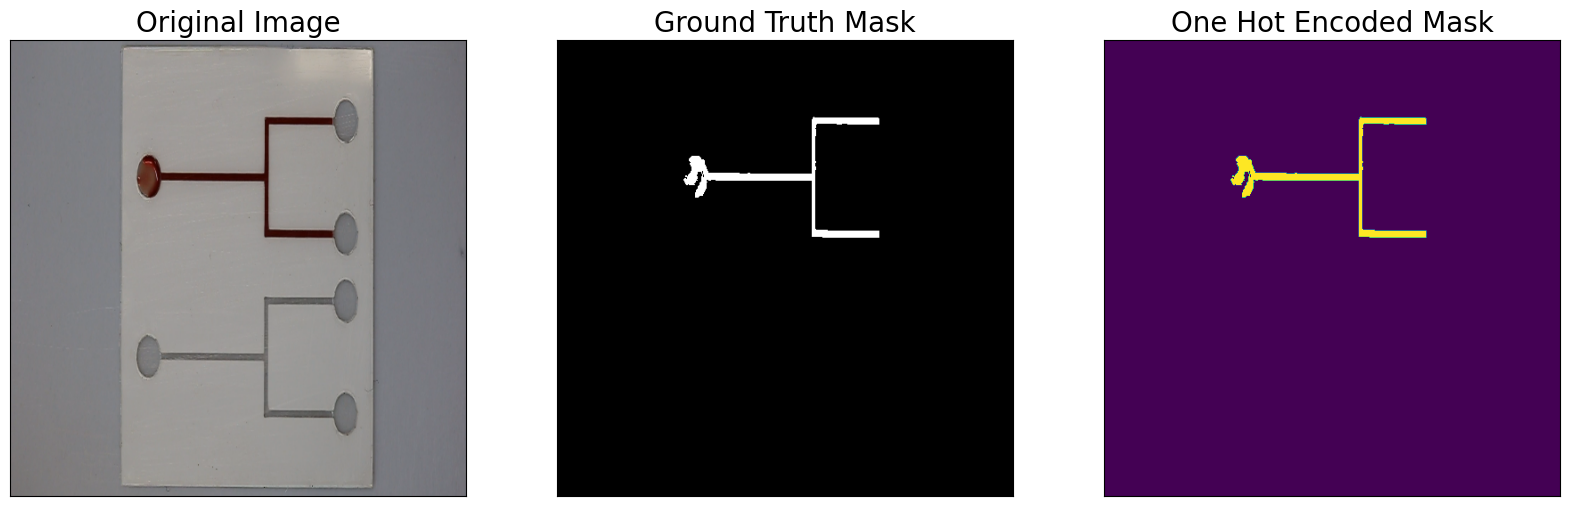

In [ ]:
augmented_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [ ]:
# ENCODER = 'resnet50'
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 55.2MB/s]


In [ ]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    valid_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 60

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    Fscore(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/road-extraction-from-satellite-images-Unet/best_model.pth'):
#     model = torch.load('../input/road-extraction-from-satellite-images-Unet/best_model.pth', map_location=DEVICE)
#     print('Loaded pre-trained Unet+ model!')

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s, dice_loss - 0.3534, iou_score - 0.6534, fscore - 0.7898]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s, dice_loss - 0.2559, iou_score - 0.8021, fscore - 0.8898]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s, dice_loss - 0.199, iou_score - 0.9402, fscore - 0.9691] 
Model saved!

Epoch: 3
valid: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s, dice_loss - 0.1773, iou_score - 0.9662, fscore - 0.9828]
Model saved!

Epoch: 4
valid: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s, dice_loss - 0.1686, iou_score - 0.9682, fscore - 0.9838]
Model saved!

Epoch: 5
valid: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s, dice_loss - 0.1554, iou_score - 0.9772, fscore - 0.9885]
Model saved!

Epoch: 6
valid: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s, dice_loss - 0.1428, iou_score - 0.9838, fscore - 0.9918]
Model saved!

Epoch: 7
valid: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s, dice_l

Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded Unet model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/road-extraction-from-satellite-images-Unet/best_model.pth'):
#     best_model = torch.load('../input/road-extraction-from-satellite-images-Unet/best_model.pth', map_location=DEVICE)
#     print('Loaded Unet model from a previous commit.')

Loaded Unet model from this run.


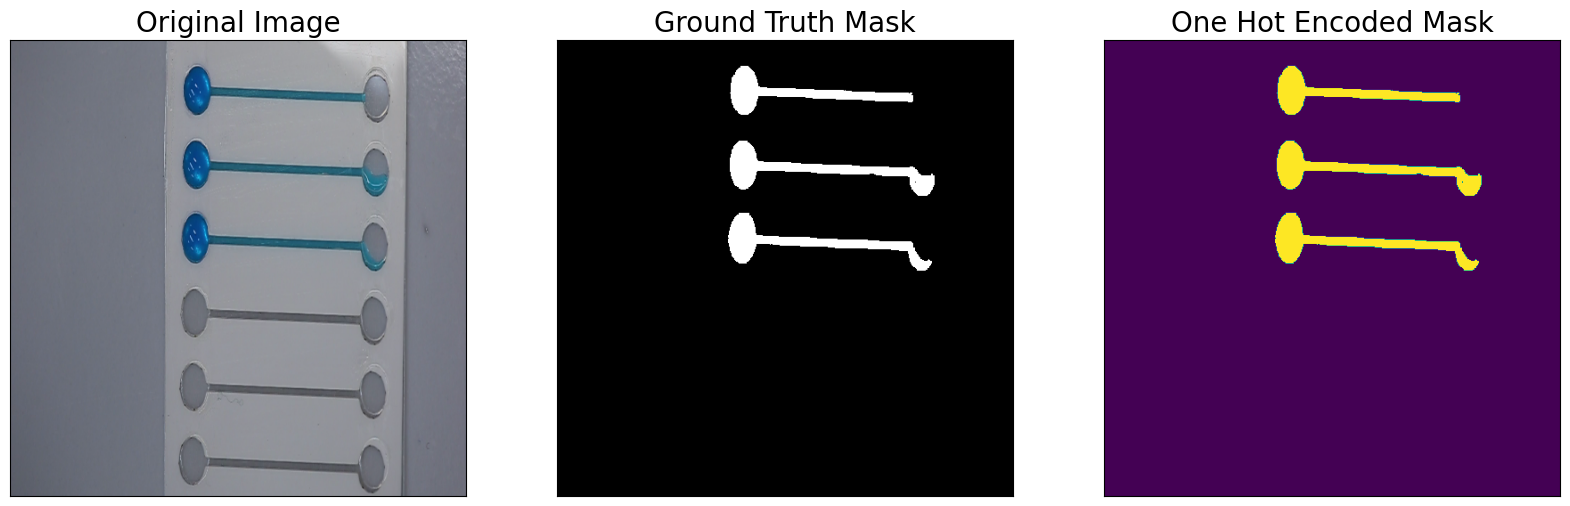

In [ ]:
# create test dataloader to be used with Unet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    valid_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = RoadsDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

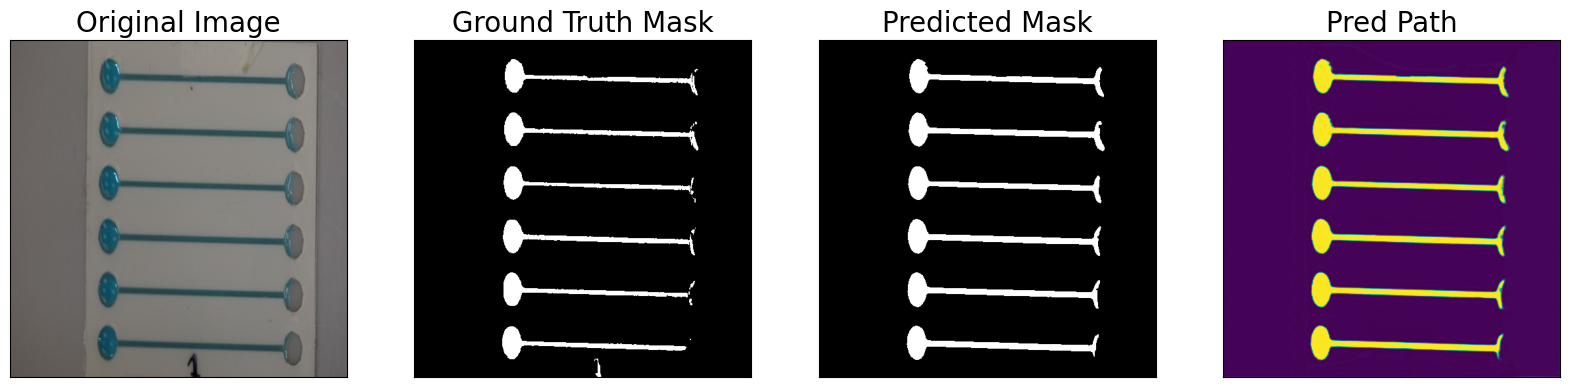

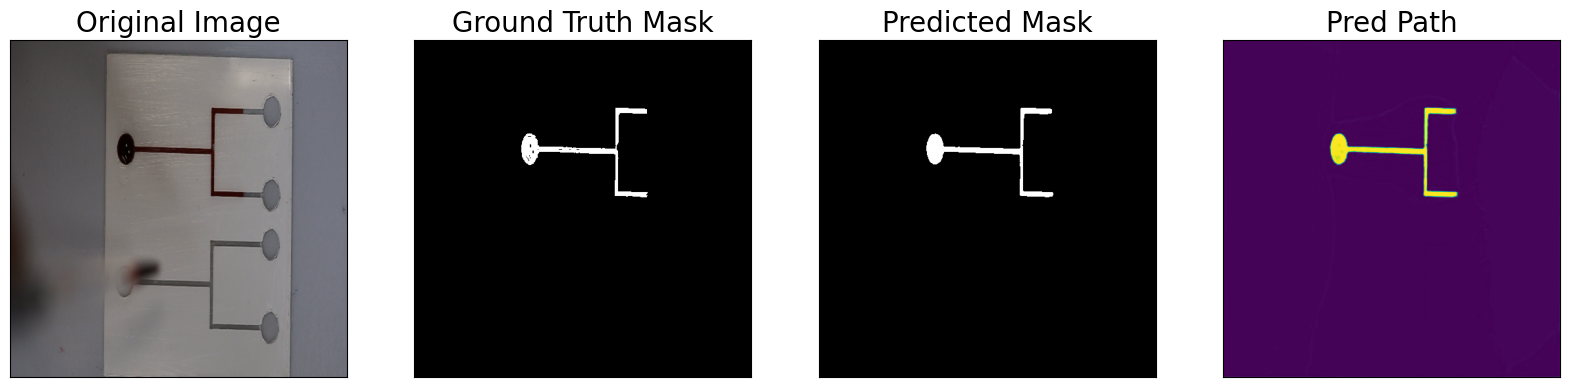

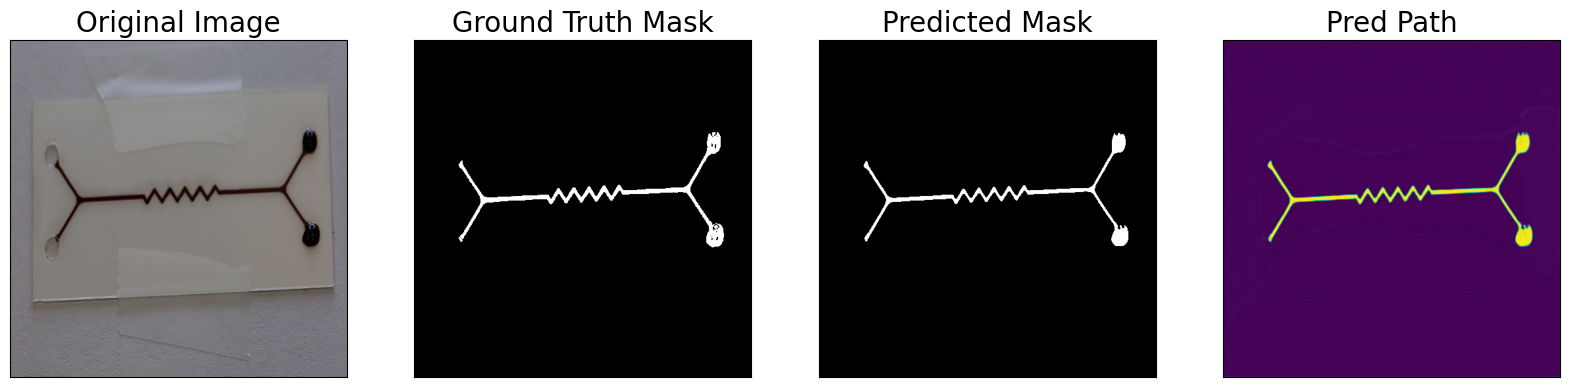

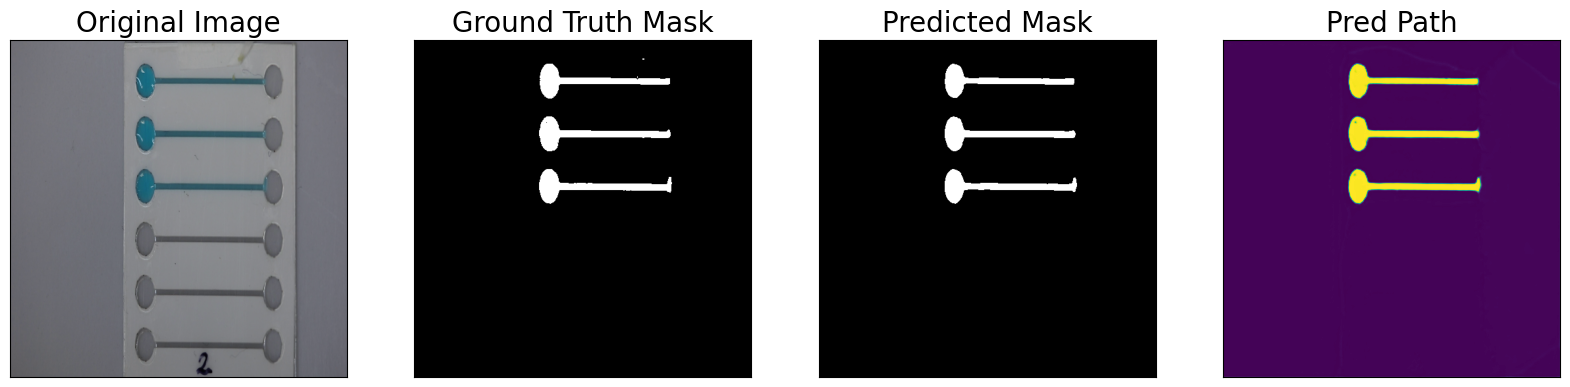

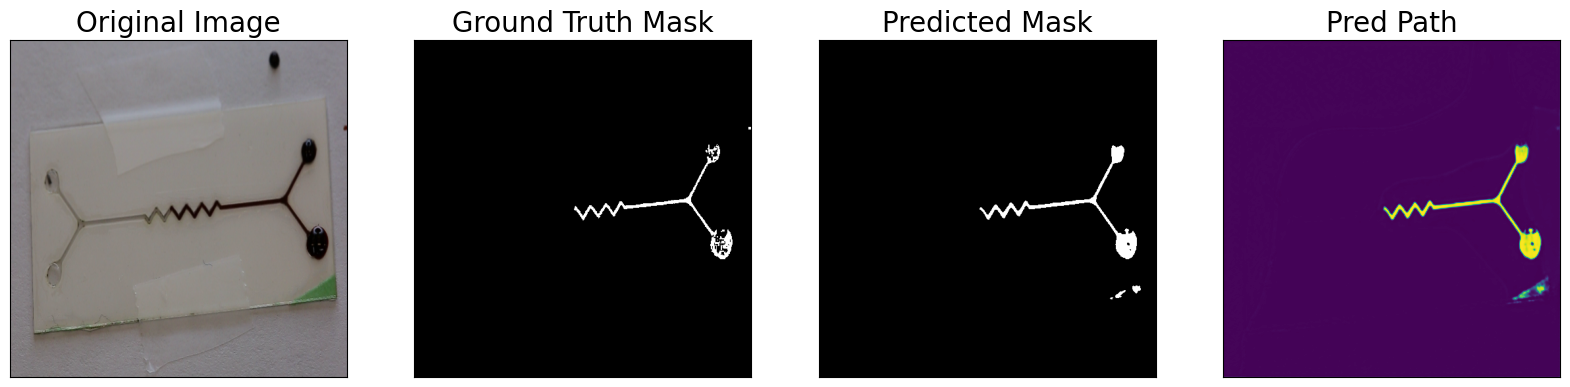

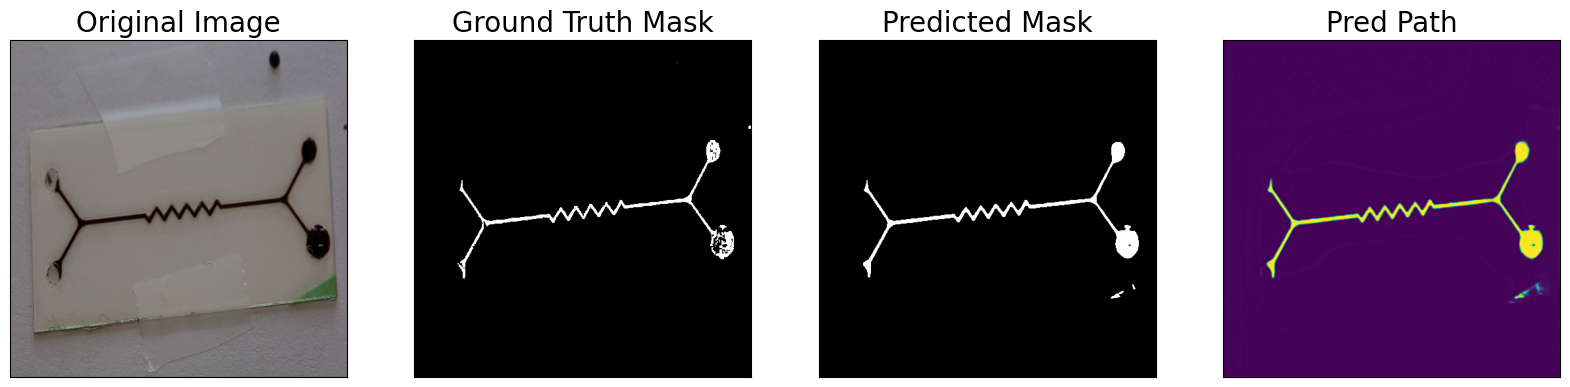

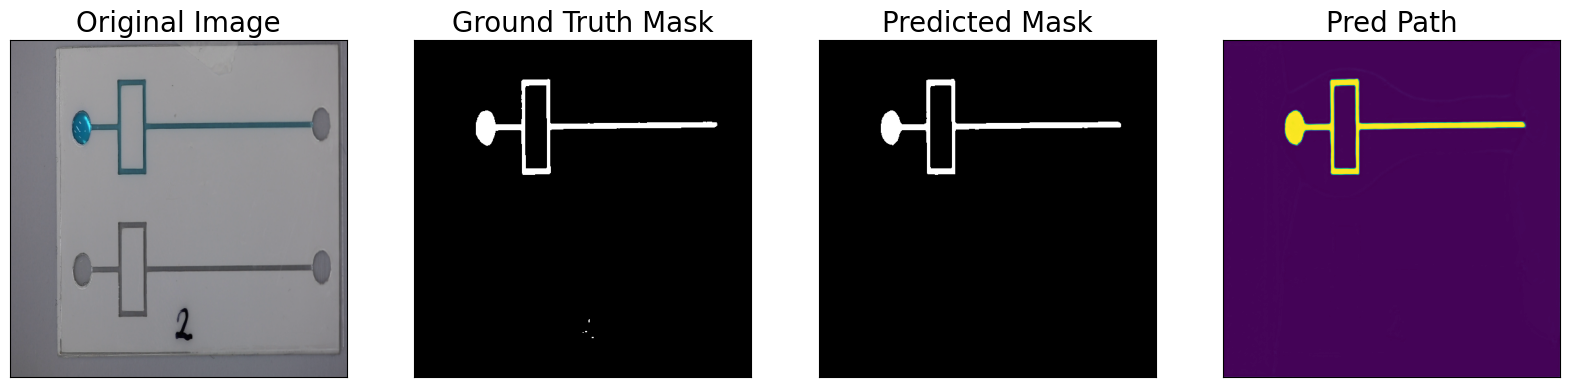

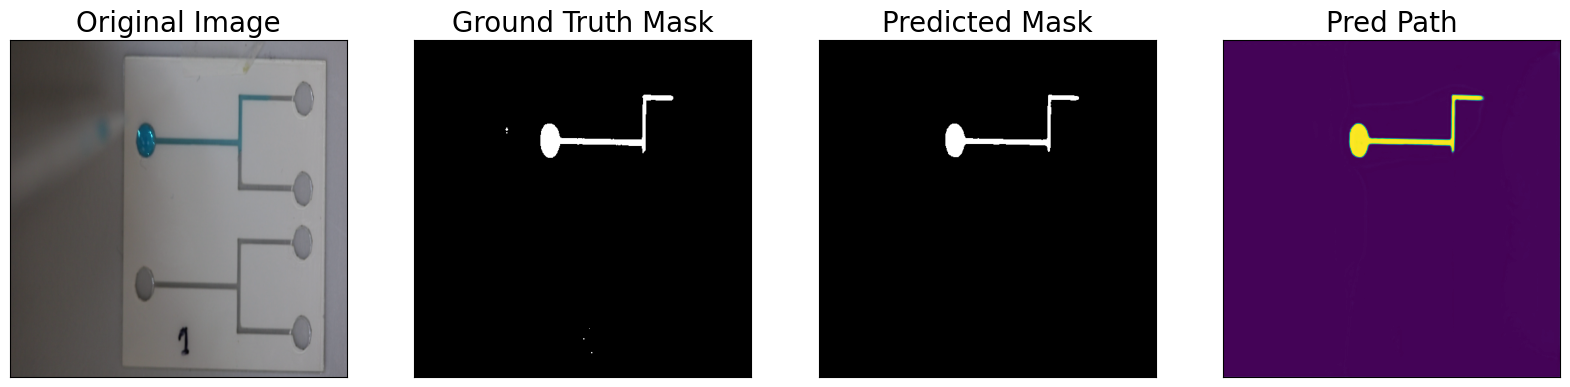

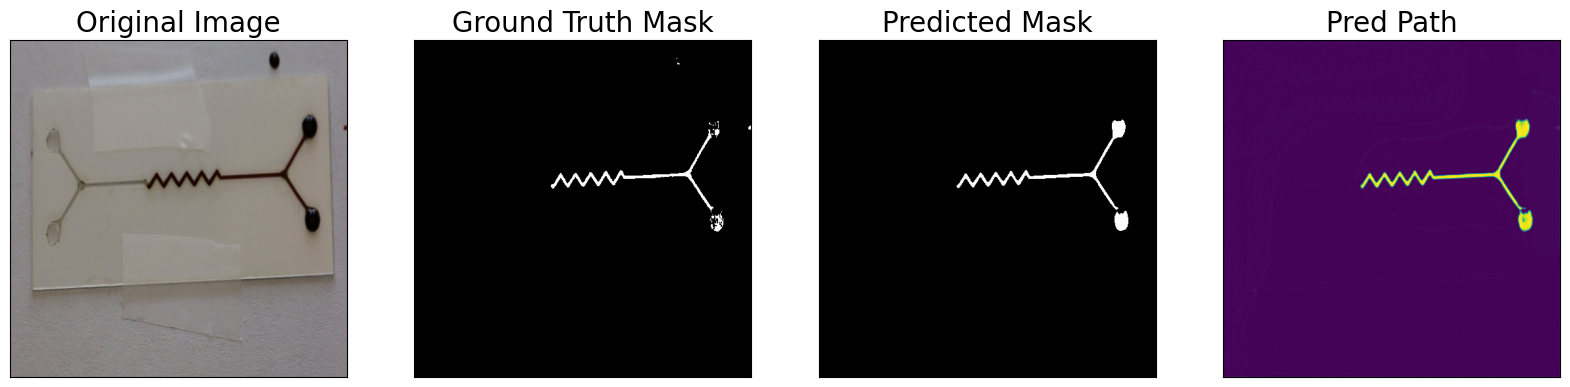

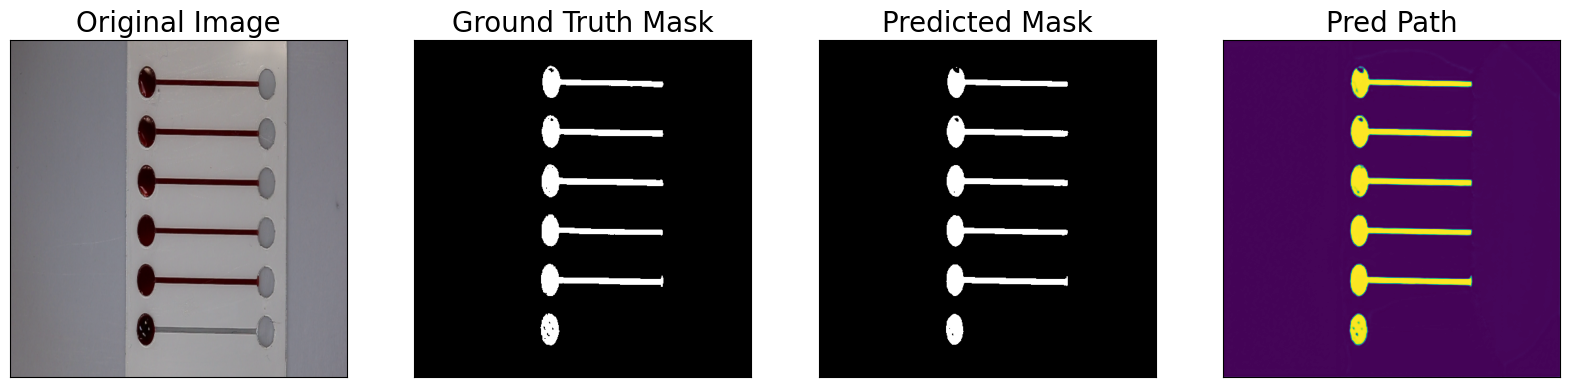

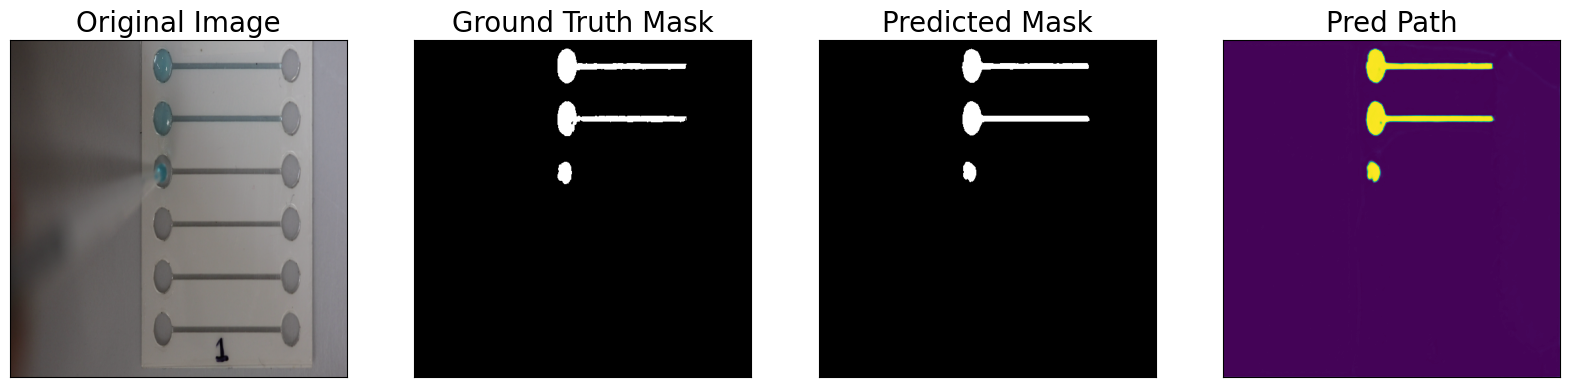

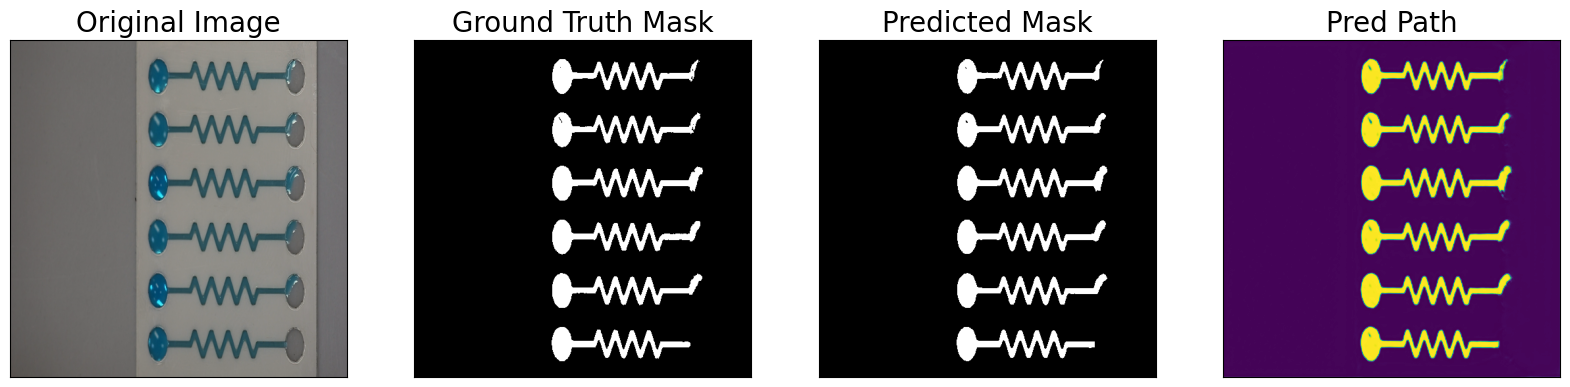

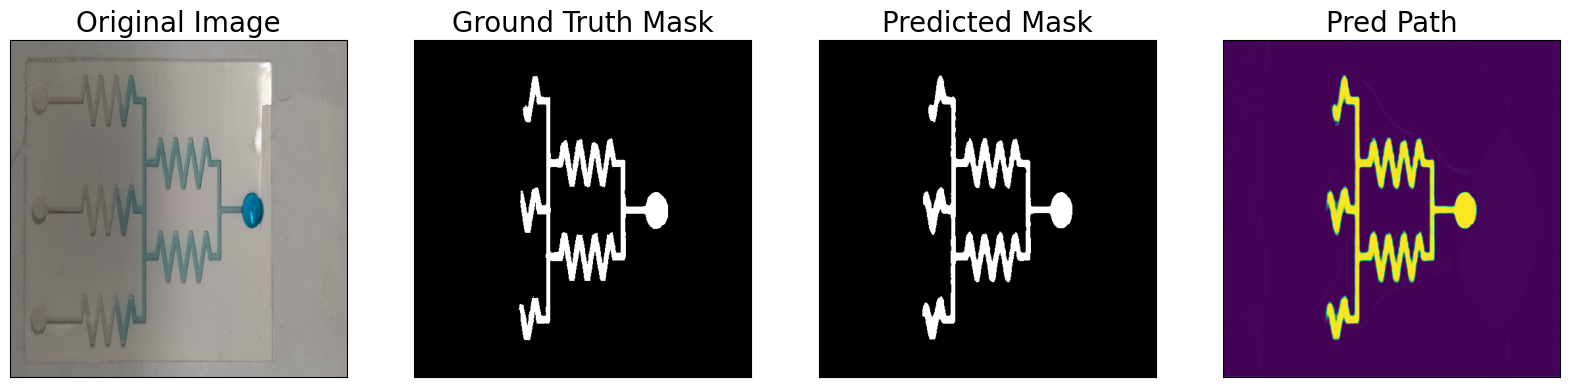

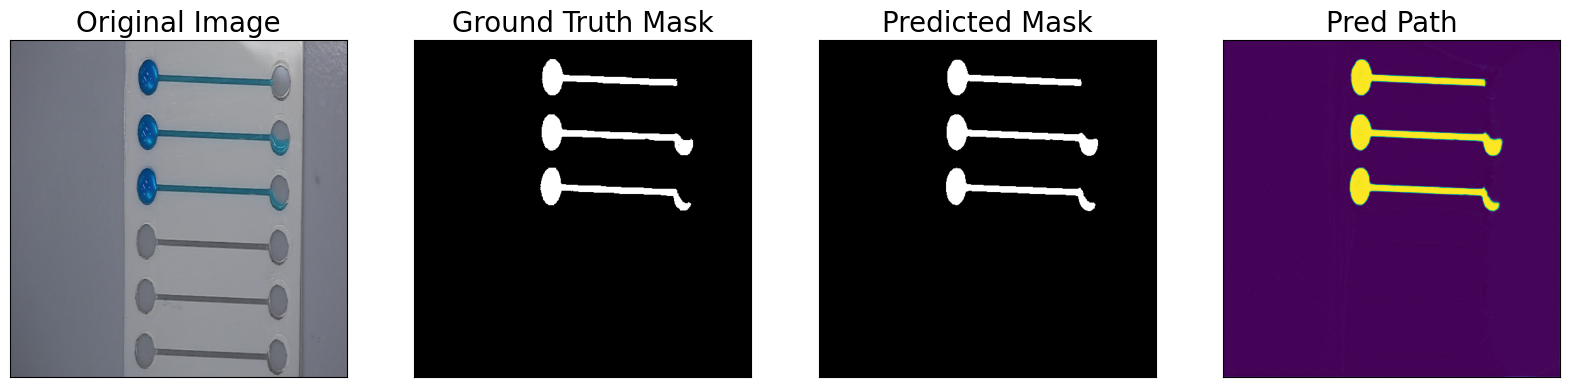

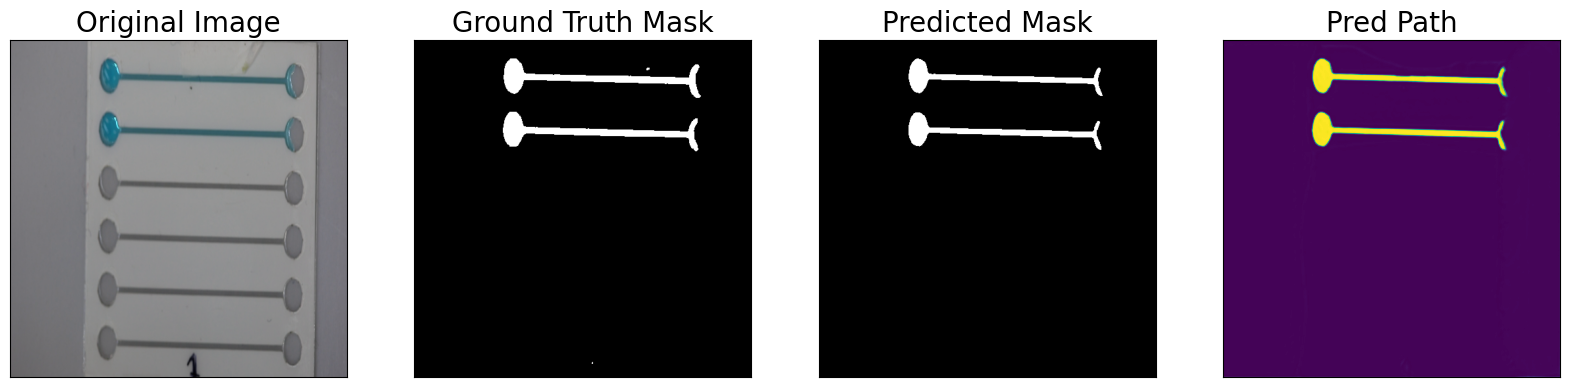

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_path = pred_mask[:,:,select_classes.index('path')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_path = pred_path
    )

In [ ]:
# Function to convert mask images to binary arrays
def mask_to_array(mask_path):
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    # Assuming the segmentation mask is binary (0 and 255)
    return (mask_array > 0).astype(int)

In [ ]:
image, gt_mask = test_dataset[1]
image_vis = test_dataset_vis[1][0].astype('uint8')
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
# Predict test image
pred_mask = best_model(x_tensor)
pred_mask = pred_mask.detach().squeeze().cpu().numpy()
# Convert pred_mask from `CHW` format to `HWC` format
pred_mask = np.transpose(pred_mask,(1,2,0))
# Get prediction channel corresponding to foreground
pred_path = pred_mask[:,:,select_classes.index('path')]
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
# Convert gt_mask from `CHW` format to `HWC` format
gt_mask = np.transpose(gt_mask,(1,2,0))
gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)

print(pred_mask.shape)
print(gt_mask.shape)


(512, 512, 3)
(512, 512, 3)


In [ ]:
from sklearn.metrics import confusion_matrix

predicted_masks =[]
ground_truth_masks  = []

for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_path = pred_mask[:,:,select_classes.index('path')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)

    predicted_masks.append(pred_mask)
    ground_truth_masks.append(gt_mask)

# Flatten the 2D arrays to 1D arrays
predicted_flat = np.concatenate(predicted_masks).ravel()
ground_truth_flat = np.concatenate(ground_truth_masks).ravel()


# Create confusion matrix
conf_matrix = confusion_matrix(ground_truth_flat, predicted_flat)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[11367054    30084]
 [   17856   381486]]


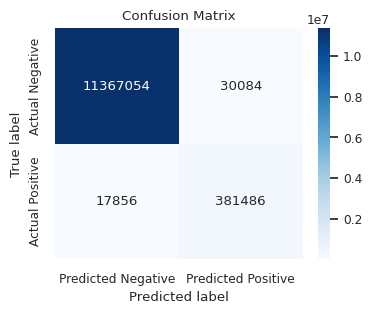

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plotting the confusion matrix as a heatmap
sns.set(font_scale=0.8)
plt.figure(figsize=(4, 3))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

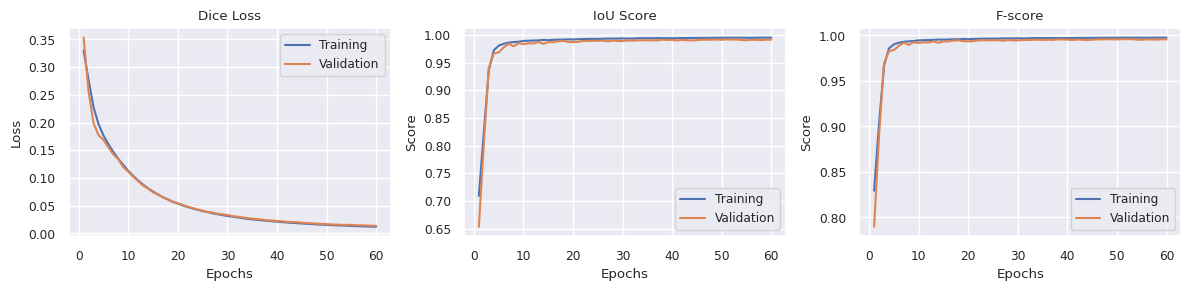

In [ ]:
# Extracting values for each metric
train_dice_loss = [result['dice_loss'] for result in train_logs_list]
train_iou_score = [result['iou_score'] for result in train_logs_list]
train_fscore = [result['fscore'] for result in train_logs_list]

valid_dice_loss = [result['dice_loss'] for result in valid_logs_list]
valid_iou_score = [result['iou_score'] for result in valid_logs_list]
valid_fscore = [result['fscore'] for result in valid_logs_list]

# Plotting
epochs = range(1, len(train_logs_list) + 1)

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_dice_loss, label='Training')
plt.plot(epochs, valid_dice_loss, label='Validation')
plt.title('Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_iou_score, label='Training')
plt.plot(epochs, valid_iou_score, label='Validation')
plt.title('IoU Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_fscore, label='Training')
plt.plot(epochs, valid_fscore, label='Validation')
plt.title('F-score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()